In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
FIG_PATH = Path('./figures/1DGP_overSquashing_figures')
FIG_PATH.mkdir(exist_ok=True)

DATASET_PATH = Path('./dataset.nosync')
DATASET_PATH.mkdir(exist_ok=True)

In [3]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [4]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP1DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  num_locations: int = 400
  
@dataclass
class Args:  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int = 1000
  eval_frequency: int = 100
  learning_rate: float = 1e-3
  beta: float = 1e-2  # beta-VAE
  
  # Model params
  hidden_gnn_dim: int = 3
  hidden_fc_dim: int = 50
  latent_dim: int = 30
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu

GP1D_ARGS = GP1DArgs()
ARGS = Args()

In [5]:
model_name = (
    f'PriorVGAE_overSquashing_1DGP_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'beta{ARGS.beta}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}_'
    f'numLocations{GP1D_ARGS.num_locations}'
)

model_params_title = (
    '('
    f'epochs = {plotting.convert_to_string_int(ARGS.epochs)}, '
    f'lr = {ARGS.learning_rate}, '
    f'act_fn = {jax.nn.elu.__name__}, '
    rf'$\beta = {ARGS.beta}$, '
    f'\ngnn_dim = {ARGS.hidden_gnn_dim},  fc_dim = {ARGS.hidden_fc_dim},  z_dim = {ARGS.latent_dim}'
    f'\n num_loc = {GP1D_ARGS.num_locations}'
    ')'
)

print(model_name)

PriorVGAE_overSquashing_1DGP_lr0.001_epochs1000_beta0.01_gnn3_fc50_z30_numLocations400


# Dataset: GP priors to be encoded

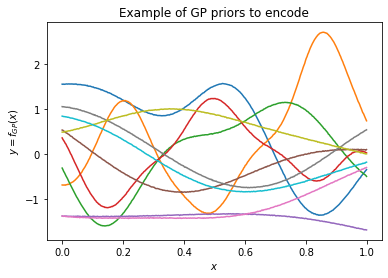

In [6]:
# GP priors to encode
X = jnp.arange(0, 1, 1/GP1D_ARGS.num_locations)

num_to_plot = 10
gp_draws = dataset_1dgp.generate_gp_batch(RNG_KEY, 
                                          X, 
                                          batch_size=num_to_plot,
                                          kernel=GP1D_ARGS.kernel)

plotting.plot_gp_draws(
    X, gp_draws,
    num_draws_to_plot=num_to_plot,
    title='Example of GP priors to encode', 
    x_label='$x$', 
    y_label='$y=f_{GP}(x)$',
)

# Building the model

In [7]:
data_filepath = DATASET_PATH / f'1DGP_numLoc{GP1D_ARGS.num_locations}_1M_train_data.npy'

OVERRIDE_SAVE = False

# Initial RNG_KEY seed is 44.
RNG_KEY, data_rng = jax.random.split(RNG_KEY)
if data_filepath.exists() and not OVERRIDE_SAVE:
    print(f"Loading dataset from {data_filepath}")
    data = np.load(data_filepath)
else:
    num_samples = 1_000_000
    data = dataset_1dgp.generate_gp_batch(data_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
    print(f"Saving dataset to {data_filepath}")
    np.save(data_filepath, np.asarray(data))

Loading dataset from dataset.nosync/1DGP_numLoc400_1M_train_data.npy


In [8]:
# Remove NaNs from dataset
data = data[~np.isnan(data).any(axis=1), :]

train_size_limit = 700_000
val_size = 11_000  # + 1000 for the final epoch evaluation and batching

# train_data = data[:train_size_limit]
train_data = data[:]
val_data = data[train_size_limit:train_size_limit+val_size]

In [9]:
BASE_GRAPH = dataset_1dgp.create_1dgp_graph(GP1D_ARGS.num_locations)

graph_train_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in train_data]
graph_val_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in val_data]

Comment: Removing linear (hidden_fc) before latent hidden layer makes samples even NOISIER

In [10]:
from functools import partial
from model import VGAEOutput
import layer

class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        output_dim: int,
        num_nodes: int,
    ):
        super().__init__()
        self._hidden_gnn_dim = hidden_gnn_dim
        self._hidden_fc_dim = hidden_fc_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim
        self._num_nodes = num_nodes
        self.act = ARGS.act_fn

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean, log_std = encoder(
            graph,
            self._hidden_gnn_dim,
            self._hidden_fc_dim,
            self._latent_dim,
            self._num_nodes,
            self.act,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = decoder(
            z,
            self._hidden_fc_dim,
            self._hidden_gnn_dim,
            self._output_dim,
            self._num_nodes,
            self.act
        )

        return VGAEOutput(mean, log_std, output)


def encoder(
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        num_nodes: int,
        act_fn: Callable = jax.nn.elu) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # Fully-connected layer
    x = graph.nodes.reshape(1, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (1, num_nodes*hidden_gnn_dim)
    
    # x = hk.Linear(hidden_fc_dim)(x)
    # x = act_fn(x)
    
    # No activation
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def decoder(
        z: jnp.ndarray,
        hidden_fc_dim: int,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (1, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((num_nodes, hidden_gnn_dim))
    graph = BASE_GRAPH._replace(nodes=z)

    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn1'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn2'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # # Graph normalization
    # NOTE :- Graph normalization on the decoder yields a shrinked GP.
    # # graph = layer.GraphwiseLayerNorm()(graph)
    
    # No activation
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'),
        add_self_edges=False,
    )
    graph = gn(graph)


    return graph

In [11]:
extend_model_params_title = True
    
extension_string = 'using_GAT = False, add_self_edges = True'

if extend_model_params_title:
    model_params_title = model_params_title[:-1] + ', ' + extension_string

# Training time

In [12]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 num_nodes=GP1D_ARGS.num_locations)(x))

## Training optimizer

In [13]:
# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=2000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

### Loss function and update

In [14]:
def training_loop(rng_key, epochs):
  @jax.jit
  def loss_fn(
      params: hk.Params, 
      rng_key: jnp.ndarray,
      graph: jraph.GraphsTuple,
  ) -> jnp.ndarray:
    """Computes VGAE loss."""
    log_likelihood_loss_fn = ARGS.loss_fn
    
    outputs: VGAEOutput = net.apply(params, rng_key, graph)
    log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
    kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
    elbo = (1.0/ARGS.beta)*log_likelihood - kld
    
    return -elbo, kld
    
  @jax.jit
  def update(
      params: hk.Params,
      rng_key: jnp.ndarray,
      opt_state: optax.OptState,
      graph: jraph.GraphsTuple,
  ):
    """Updates the parameters of the network."""
    grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

  # Initialize net with an arbitrary graph
  params_rng, train_rng = jax.random.split(rng_key)

  init_graph = graph_train_data[0]
  params = net.init(params_rng, init_graph)
  opt_state = optimizer.init(params)

  train_losses = []
  val_losses = []
  train_klds = []
  val_klds = []

  train_size = len(graph_train_data)
  val_size = len(graph_val_data)

  eval_counter: int = 0

  training_start_time = time.time()
  print('using: ', ARGS.loss_fn)
  for epoch in range(epochs):
    update_rng = jax.random.fold_in(train_rng, epoch)

    train_graph_batch = graph_train_data[epoch % train_size]
    params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
      
    if epoch % ARGS.eval_frequency == 0 or epoch == (epochs - 1):
      evaluate_rng = jax.random.fold_in(update_rng, epoch)
      train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
      
      train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
      
      val_graph_batch = graph_val_data[eval_counter]
      val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
      
      print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
            f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
            # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
      )
        
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())
      train_klds.append(train_kld.item())
      val_klds.append(val_kld.item())
      
      eval_counter += 1

  training_end_time = time.time() - training_start_time
  print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')
  
  return params

In [15]:
all_epochs = [100, 1000, 10000, 100000]
all_params = []
for epoch in all_epochs:
    loop_rng = jax.random.fold_in(RNG_KEY, epoch)
    params = training_loop(loop_rng, epoch)
    all_params.append(params)

using:  <function compute_mse_loss at 0x14f3b1040>
21:49:55 STEP: 0; Train loss: 89.906; Validation loss: 160.184; 
21:49:55 STEP: 99; Train loss: 11.378; Validation loss: 46.923; 
Training took: (2.097 secs; equivalently 0.035 mins)
using:  <function compute_mse_loss at 0x14f3b1040>
21:49:56 STEP: 0; Train loss: 75.871; Validation loss: 168.226; 
21:49:57 STEP: 100; Train loss: 19.252; Validation loss: 37.233; 
21:49:57 STEP: 200; Train loss: 41.468; Validation loss: 32.385; 
21:49:57 STEP: 300; Train loss: 49.440; Validation loss: 35.431; 
21:49:57 STEP: 400; Train loss: 58.346; Validation loss: 16.439; 
21:49:57 STEP: 500; Train loss: 75.566; Validation loss: 21.327; 
21:49:57 STEP: 600; Train loss: 36.787; Validation loss: 44.508; 
21:49:57 STEP: 700; Train loss: 56.608; Validation loss: 29.311; 
21:49:57 STEP: 800; Train loss: 28.058; Validation loss: 23.543; 
21:49:57 STEP: 900; Train loss: 24.395; Validation loss: 22.699; 
21:49:57 STEP: 999; Train loss: 30.657; Validation loss:

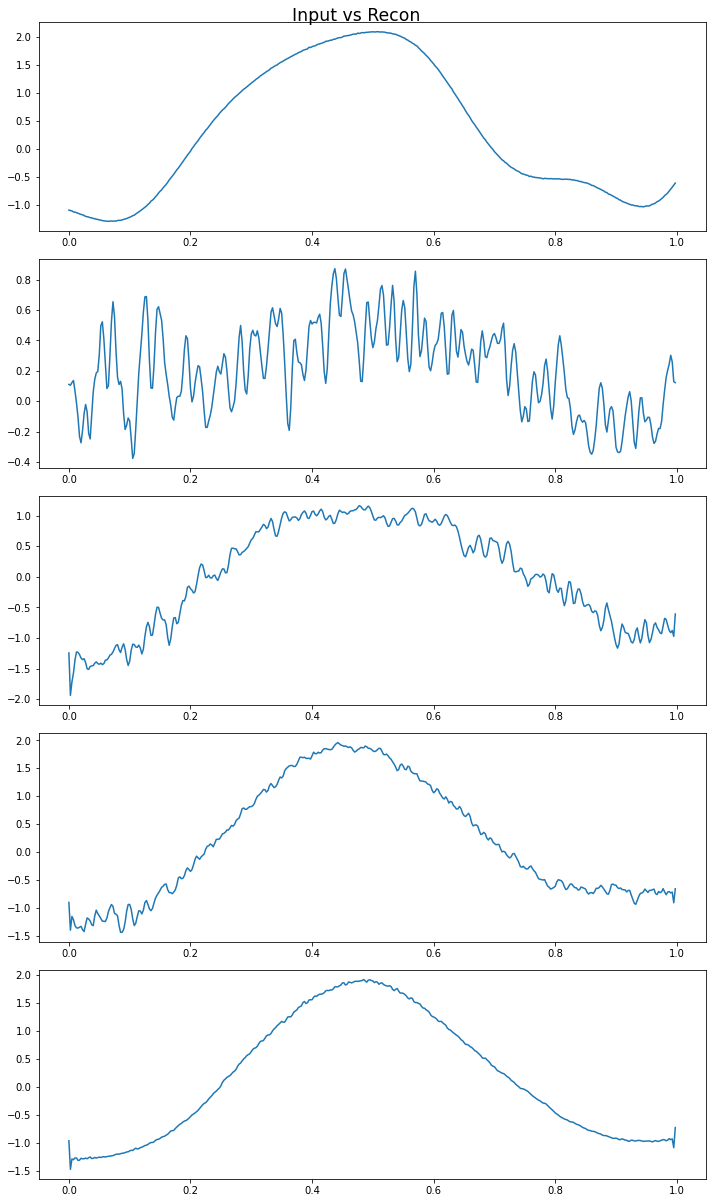

In [16]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

fig, axes = plt.subplots(len(all_params)+1, 1, figsize=(10, 17))

sample_idx = 0

original_data = val_data[sample_idx]
graph_data = graph_val_data[sample_idx]

original_gp = jnp.ravel(original_data)

axes[0].plot(X, original_gp)

for idx, params in enumerate(all_params, 1):
    outputs = net.apply(params, rng_recon, graph_data)
    recon_gp = jnp.ravel(outputs.output.nodes)
    axes[idx].plot(X, recon_gp)

fig.suptitle(f'Input vs Recon', fontsize='xx-large')

plt.tight_layout()
plt.show()

# input_v_recon_path = FIG_PATH / 'recon_figures'
# input_v_recon_path.mkdir(exist_ok=True)
# fig.savefig(input_v_recon_path / f'{model_name}.jpg', dpi=300)

In [17]:
from functools import partial

all_decoder_params = []
for params in all_params:
    decoder_params_keys = [k for k in list(params.keys()) if k.startswith('vgae/decoder')]
    decoder_params = {}
    for full_key_name in decoder_params_keys:
        key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
        decoder_params[key_name] = params[full_key_name]
        
    all_decoder_params.append(decoder_params)


decoder_net_fn = partial(decoder,
                        hidden_fc_dim=ARGS.hidden_fc_dim,
                        hidden_gnn_dim=ARGS.hidden_gnn_dim,
                        output_dim=ARGS.output_dim,
                        num_nodes=GP1D_ARGS.num_locations)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [18]:
def decoder_predictive_model(decoder_params):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(decoder_params, z).nodes)
    numpyro.deterministic('f', vgae_out)

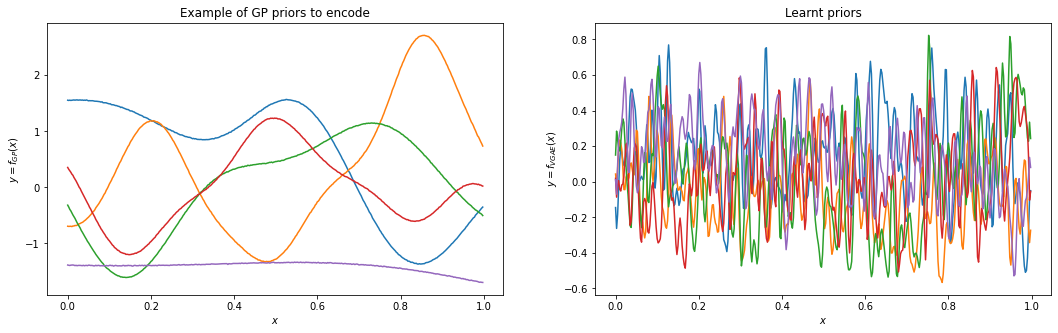

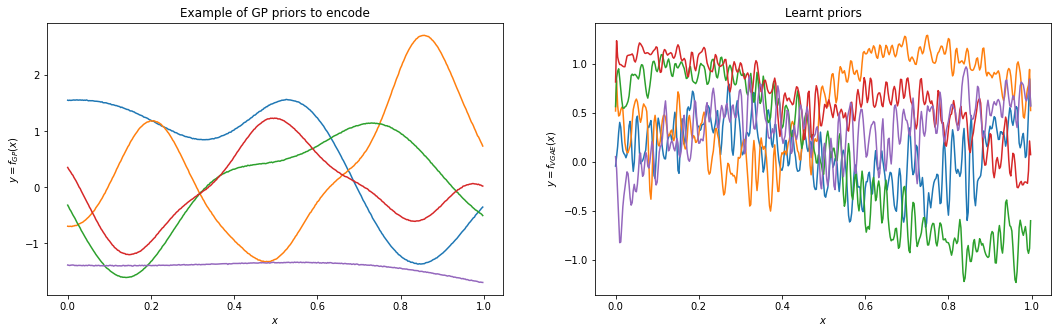

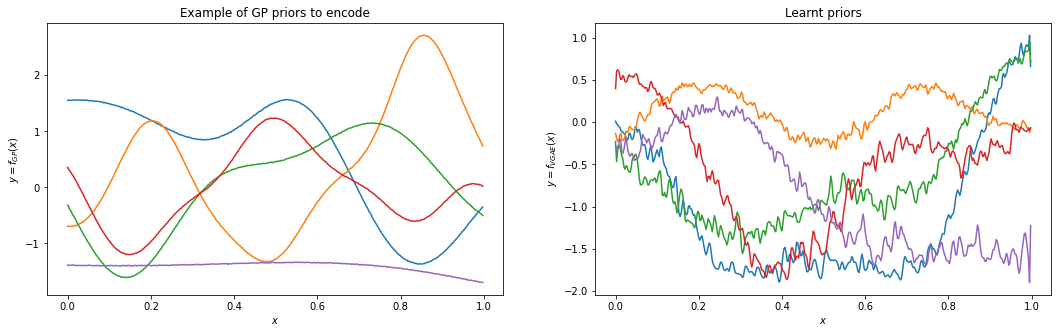

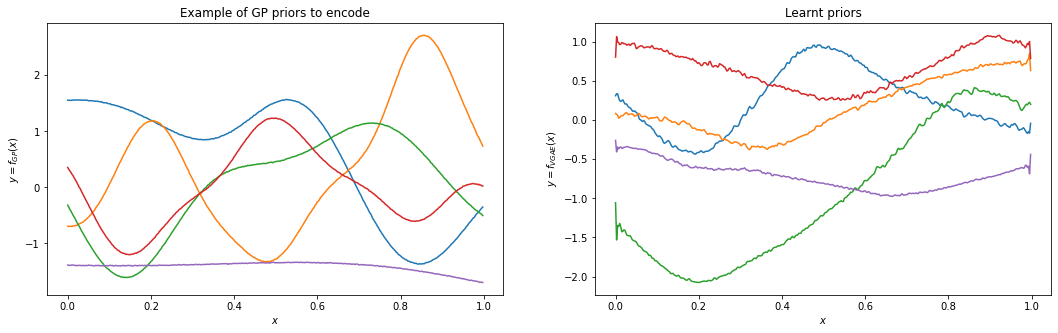

In [19]:
# Rough comparison of the shape of GP draws with learnt VGAE priors.

for decoder_params in all_decoder_params:
  # Drawing VGAE priors.
  RNG_KEY, vgae_sample_rng = jax.random.split(RNG_KEY)
  vgae_draws = Predictive(
    decoder_predictive_model, num_samples=10)(vgae_sample_rng, decoder_params)['f']

  # Plotting the GP draws and VGAE draws.
  _, ax = plt.subplots(1, 2, figsize=(18, 5))

  plotting.plot_gp_draws(X, gp_draws, num_draws_to_plot=5, 
                      ax=ax[0], title='Example of GP priors to encode', y_label='$y=f_{GP}(x)$')

  plotting.plot_gp_draws(X, vgae_draws, num_draws_to_plot=5, 
                      ax=ax[1], title=f'Learnt priors', y_label='$y=f_{VGAE}(x)$', )

  plt.show()

In [20]:
# Comparing distribution of GP draws with learnt VGAE priors.
RNG_KEY, gp_rng, vgae_rng = jax.random.split(RNG_KEY, 3)

num_samples = 1000
gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
vgae_draws = Predictive(decoder_predictive_model, num_samples=num_samples)(vgae_rng)['f']

# Computing the mean and HPDI of the GP draws and VGAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vgae_draws = vgae_draws[~np.isnan(vgae_draws).any(axis=1), :]
mean_vgae = jnp.nanmean(vgae_draws, axis=0)
hpdi_vgae = hpdi(vgae_draws, 0.9)

TypeError: decoder_predictive_model() missing 1 required positional argument: 'decoder_params'

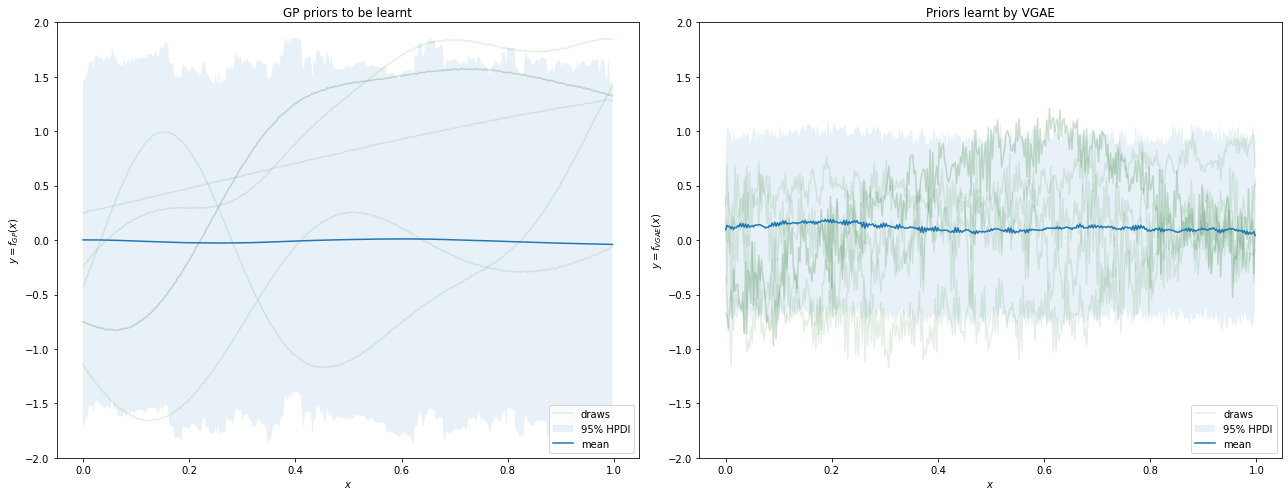

In [ ]:

# Plotting the GP draws and VGAE draws.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vgae = 0.1
num_draws_to_plot = 5
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to be learnt', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, mean_vgae, hpdi_vgae,
    lines_alpha_vgae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='Priors learnt by VGAE',
    y_label=r'$y=f_{VGAE}(x)$')

# fig.suptitle(f'GP Priors vs Learnt VGAE Priors \n{model_params_title}', fontsize='xx-large')
# fig.suptitle(f'GP Priors vs Learnt VGAE Priors', fontsize='xx-large')

plt.tight_layout()
plt.show()

estimate_plot_path = FIG_PATH / 'estimate_figures'  
estimate_plot_path.mkdir(exist_ok=True)
fig.savefig(estimate_plot_path / f'{model_name}.jpg', dpi=300)

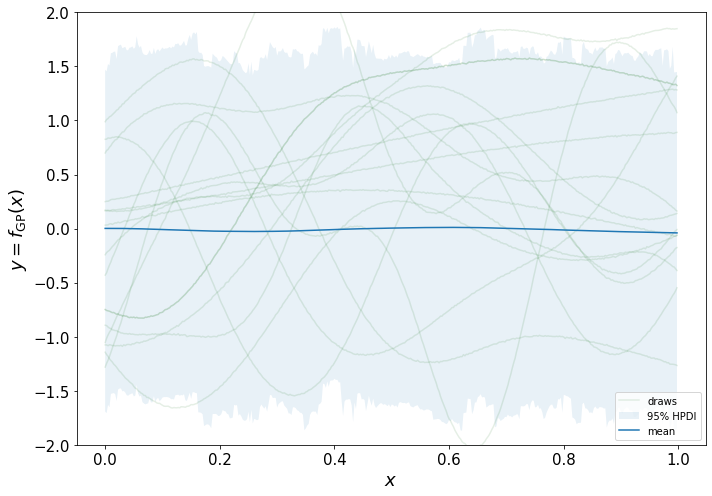

In [ ]:
# Plotting the GP draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('GP priors to be learnt', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{GP}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
save_to_dir.mkdir(exist_ok=True)
fig.savefig(save_to_dir / '1DGP_priors_GP.jpg', dpi=300)

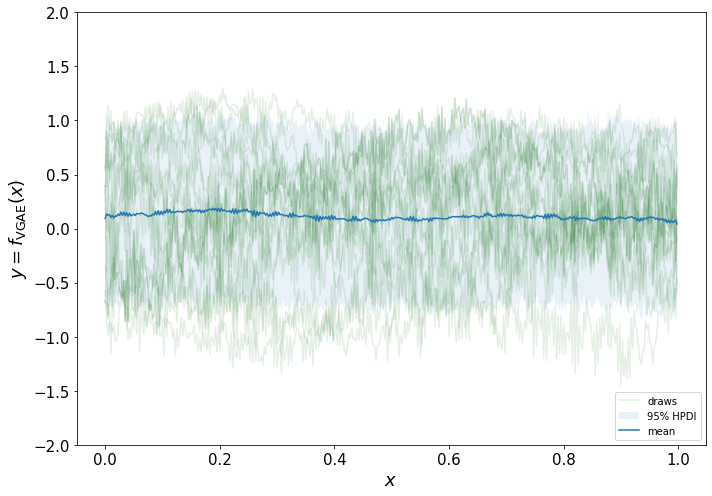

In [ ]:
# Plotting the GP draws and VGAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, 
    mean_vgae, hpdi_vgae,lines_alpha_vgae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('Priors learnt by VGAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VGAE}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_priors_VGAE.jpg', dpi=300)

In [ ]:
assert False, 'Inference is turned off'

AssertionError: Inference is turned off

# Inference on Observed Data

In [ ]:
def vgae_mcmc_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP1D_ARGS.decoder_params, z).nodes)
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

## Ground truth and observed data

In [ ]:
RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(10))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(8))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(6))
# RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
  gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
gp_draw = draws['f'].T  # True data
y_draw = draws['y'].T  # True data + noise

assert not jnp.isnan(y_draw).any(), 'NaNs in y_draw'

# Choose indices of datapoints for inference.
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([71, 85, 111, 291, 314, 380]),  # 6 observed datapoints
# ]
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([71, 85, 147, 291, 314, 380]),  # 6 observed datapoints
# ]
obs_locations = [
  jnp.array([122, 321]),  # 2 observed datapoints
  jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
  jnp.array([71, 85, 147, 275, 314, 380]),  # 6 observed datapoints
]

In [ ]:
mean_post_preds_list = []
hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
predictions_list = []
mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vgae_mcmc_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    mcmc_objs.append(mcmc)

    predictions = Predictive(vgae_mcmc_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    predictions_list.append(predictions)
    mean_post_preds_list.append(mean_post_pred)
    hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_56585/2587952414.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:05<00:00, 346.16it/s, 63 steps of size 8.89e-02. acc. prob=0.85]



MCMC elapsed time: 28.678017139434814


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_56585/2587952414.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 4


sample: 100%|██████████| 2000/2000 [00:09<00:00, 200.57it/s, 127 steps of size 3.44e-02. acc. prob=0.94]



MCMC elapsed time: 33.7352020740509


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_56585/2587952414.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 6


sample: 100%|██████████| 2000/2000 [00:03<00:00, 644.89it/s, 31 steps of size 2.22e-01. acc. prob=0.81]



MCMC elapsed time: 15.220324993133545


In [ ]:
def compute_ess(mcmc_obj):
    ss = numpyro.diagnostics.summary(mcmc_obj.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all effects : " + str(round(r)))
    
for mcmc in mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 2313
Average ESS for all effects : 2009
Average ESS for all effects : 2318


In [ ]:
mcmc_objs[-1].print_summary(exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.21      0.36     -1.22     -1.82     -0.62   1128.05      1.00
      f[1]     -1.31      0.42     -1.30     -1.98     -0.61   1129.62      1.00
      f[2]     -1.46      0.45     -1.45     -2.21     -0.72   1115.65      1.00
      f[3]     -1.34      0.41     -1.33     -1.97     -0.61   1137.04      1.00
      f[4]     -1.26      0.40     -1.25     -1.93     -0.61   1121.04      1.00
      f[5]     -1.35      0.40     -1.34     -1.98     -0.65   1138.08      1.00
      f[6]     -1.38      0.41     -1.37     -2.05     -0.68   1140.95      1.00
      f[7]     -1.37      0.40     -1.36     -1.98     -0.66   1140.27      1.00
      f[8]     -1.37      0.39     -1.36     -1.99     -0.69   1121.94      1.00
      f[9]     -1.38      0.40     -1.37     -1.99     -0.69   1145.13      1.00
     f[10]     -1.36      0.38     -1.35     -1.95     -0.69   1128.00      1.00
     f[11]     -1.39      0

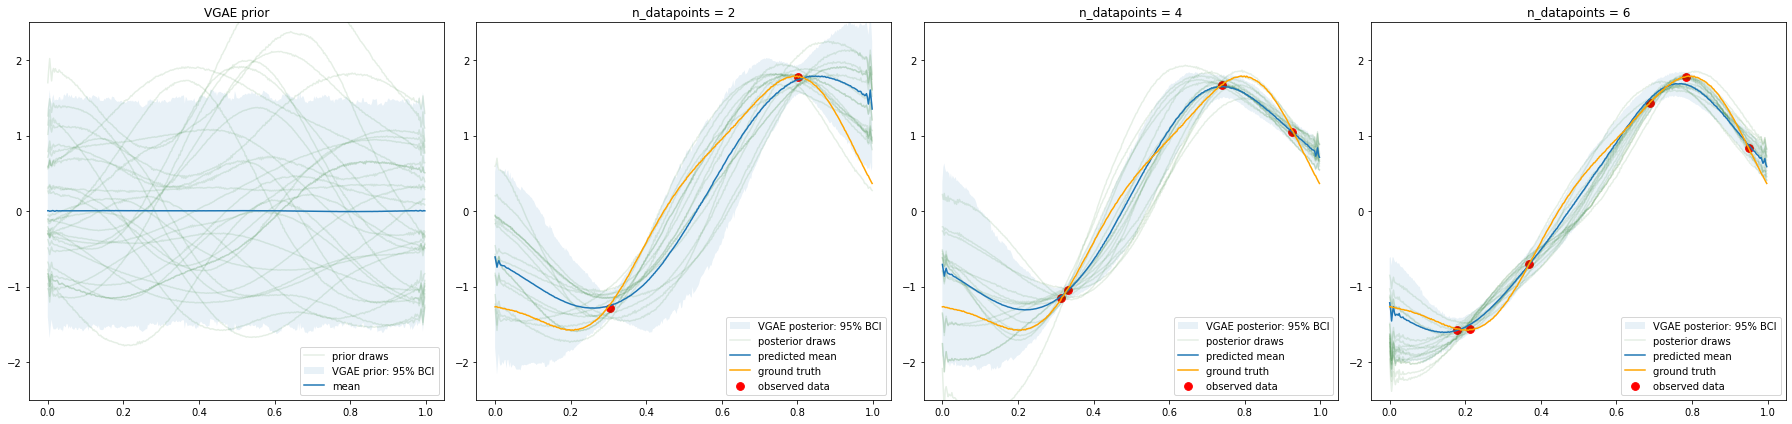

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VGAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VGAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VGAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VGAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

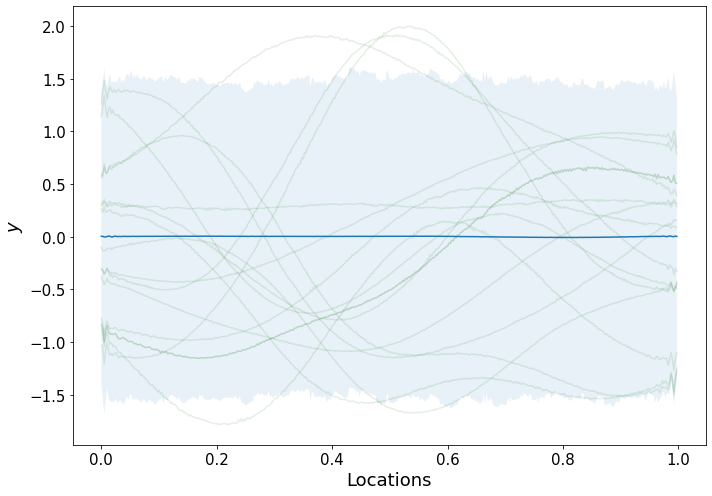

In [ ]:
# Plotting results after inference using MCMC.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    ax.plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
ax.plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
ax.fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
ax.plot(X, mean_prior_pred, label='mean')
# ax.set_title('VAE prior')

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show();

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_inference_1.jpg', dpi=300)

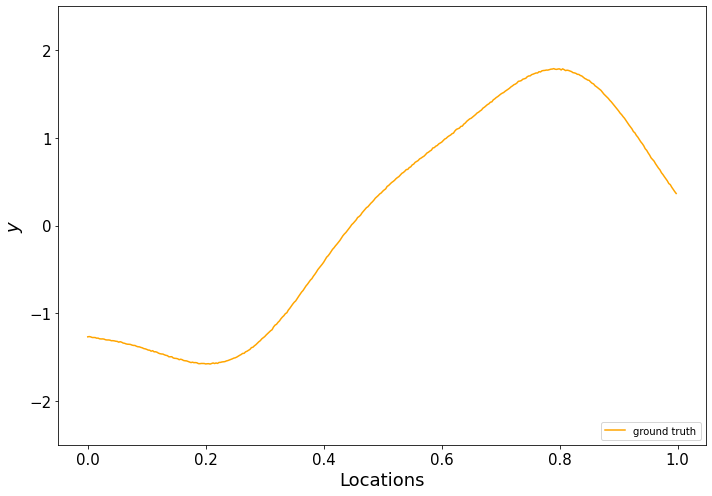

In [ ]:
# Plotting VAE posterior predictive
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(X, gp_draw, label='ground truth', color='orange')
# ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / f'1DGP_inference_00.jpg', dpi=300)

n_datapoints = 2


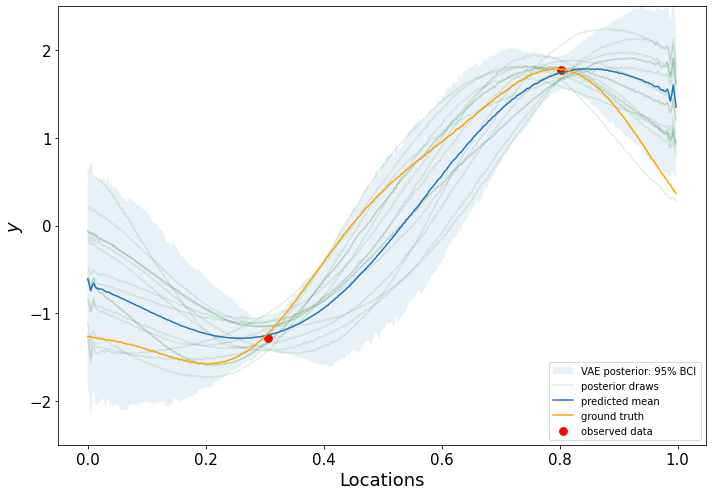

n_datapoints = 4


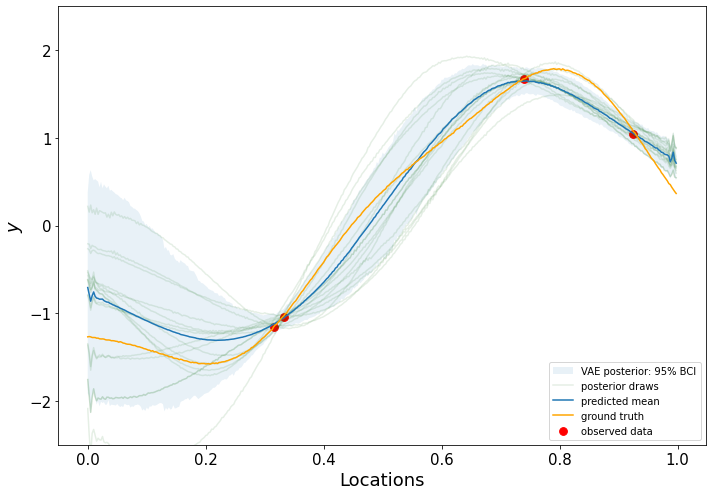

n_datapoints = 6


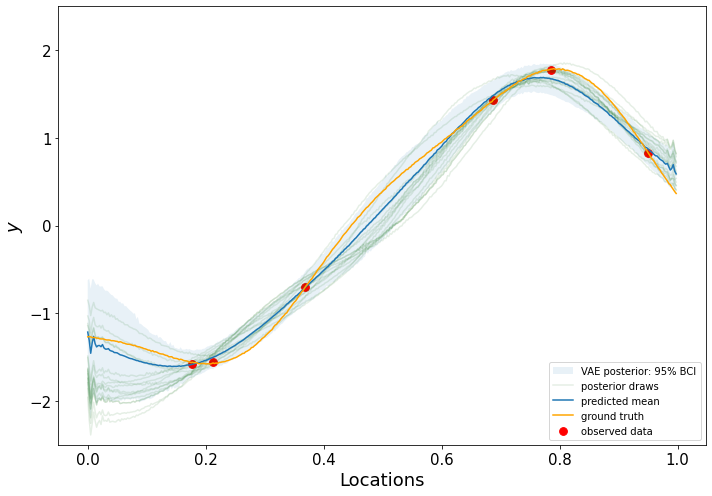

In [ ]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    ax.fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    ax.set_xlabel('Locations', fontsize=18)
    ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    plt.tight_layout()
    plt.show()
    
    save_to_dir = FIG_PATH / 'publication'
    fig.savefig(save_to_dir / f'1DGP_inference_{idx+2}.jpg', dpi=300)

In [ ]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgae (2) = 0.20761044323444366
mse_vgae (4) = 0.05168772116303444
mse_vgae (6) = 0.015989668667316437


Text(0.5, 1.0, 'VGAE covariance matrix')

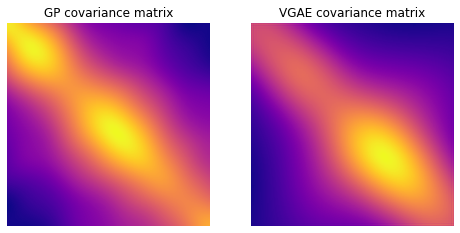

In [ ]:
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(44), 3)
RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(6), 3)
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(16), 3)

gp_predictive = Predictive(dataset_1dgp.gp_predictive_model, num_samples=100)
gp_draws = gp_predictive(gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, kernel_jitter=1e-5)['y']
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

vgae_predictive = Predictive(vgae_mcmc_predictive_model, num_samples=100)
vgae_draws = vgae_predictive(vgae_rng)['f']
vgae_draws = dataset_1dgp.remove_nans_from_gp(vgae_draws)

m_vgae = np.cov(np.transpose(vgae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vgae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VGAE covariance matrix')

## Priors learnt by VAE

In [ ]:
vae_model_name = '1DGP_PriorVAE_0.01lr_5000epochs_50h1Dim_50h2Dim_30latentDim_400numLocations_100batchSize'
model_path = Path('./models/') / vae_model_name

print(f"Loading VAE model from {model_path}")
vae_params = model.restore_params(model_path)

Loading VAE model from models/1DGP_PriorVAE_0.01lr_5000epochs_50h1Dim_50h2Dim_30latentDim_400numLocations_100batchSize


In [ ]:
vae_decoder_params_keys = [k for k in list(vae_params.keys()) if k.startswith('variational_auto_encoder/decoder')]
vae_decoder_params = {}
for full_key_name in vae_decoder_params_keys:
    key_name = ('/').join(full_key_name.split('/')[2:])  # remove the 'variational_auto_encoder/' prefix
    vae_decoder_params[key_name] = vae_params[full_key_name]

vae_decoder_net = hk.without_apply_rng(
    hk.transform(  
      lambda z: model.priorvae_decoder(
        z,
        hidden1_dim=50,
        hidden2_dim=50,
        output_dim=GP1D_ARGS.num_locations
    )
))

def vae_decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([30]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    numpyro.deterministic('f', vae_out)

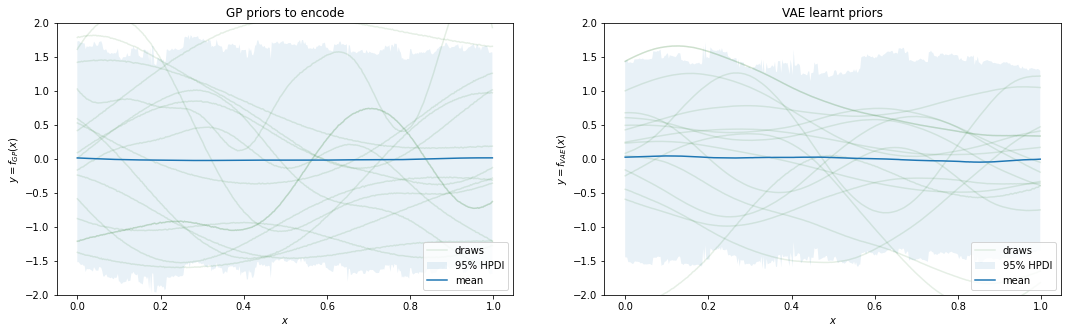

In [ ]:
# Comparing distribution of GP draws with learnt VAE priors.

RNG_KEY, rng_gp, rng_vae = jax.random.split(RNG_KEY, 3)
gp_draws = dataset_1dgp.generate_gp_batch(
    rng_gp, X, batch_size=1000, kernel=GP1D_ARGS.kernel)  # batch_size is equivalent to `num_samples`.
vae_draws = Predictive(vae_decoder_predictive_model, num_samples=1000)(rng_vae)['f']

# Computing the mean and HPDI of the GP draws and VAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vae_draws = vae_draws[~np.isnan(vae_draws).any(axis=1), :]
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

# Plotting the GP draws and VAE draws.
_, axes = plt.subplots(1, 2, figsize=(18, 5))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to encode', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vae_draws, mean_vae, hpdi_vae,
    lines_alpha_vae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='VAE learnt priors', y_label='$y=f_{VAE}(x)$')

plt.show()

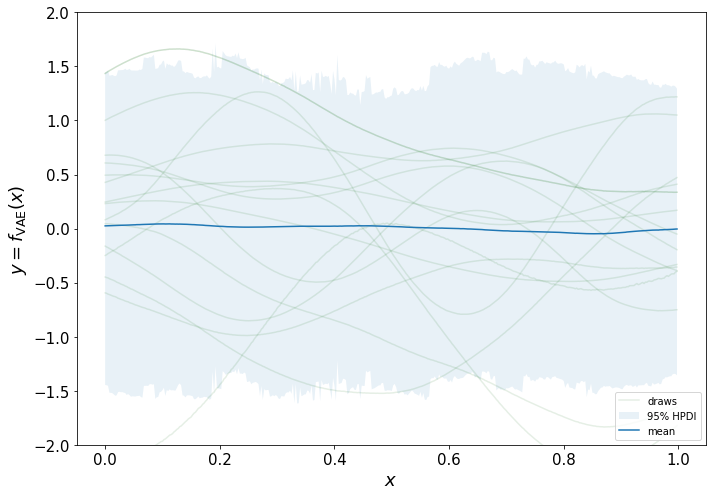

In [ ]:
# Plotting the GP draws and VAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vae_draws, 
    mean_vae, hpdi_vae,lines_alpha_vae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

# ax.set_title('Priors learnt by VAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VAE}}(x)$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)

plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_priors_VAE.jpg', dpi=300)

In [ ]:
def vae_model_mcmc(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([30]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    f = numpyro.deterministic('f', vae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
vae_mean_post_preds_list = []
vae_hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
vae_predictions_list = []
vae_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vae_model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vae_mcmc_objs.append(mcmc)

    predictions = Predictive(vae_model_mcmc, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vae_predictions_list.append(predictions)
    vae_mean_post_preds_list.append(mean_post_pred)
    vae_hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_56585/338970312.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2341.25it/s, 31 steps of size 1.29e-01. acc. prob=0.72]



MCMC elapsed time: 5.476346731185913


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_56585/338970312.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 4


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2036.44it/s, 63 steps of size 5.82e-02. acc. prob=0.89]



MCMC elapsed time: 5.373201847076416


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_56585/338970312.py:22: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 6


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2837.49it/s, 7 steps of size 4.09e-01. acc. prob=0.89] 



MCMC elapsed time: 4.348097801208496


In [ ]:
for mcmc in vae_mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 1833
Average ESS for all effects : 1922
Average ESS for all effects : 3465


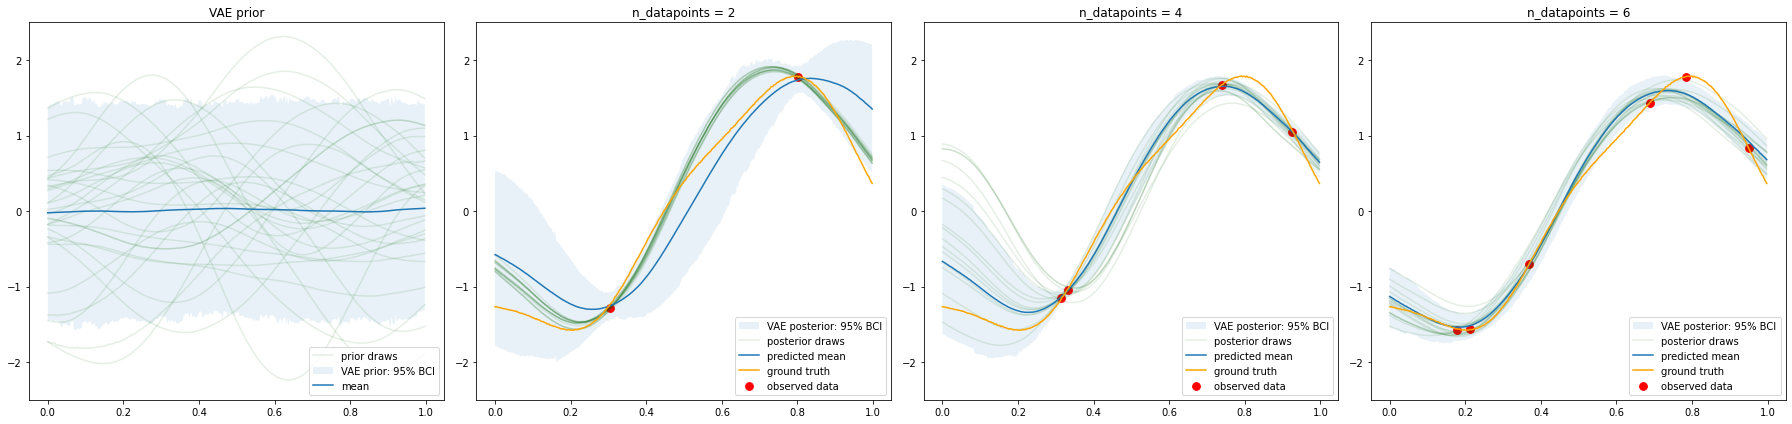

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

n_datapoints = 2


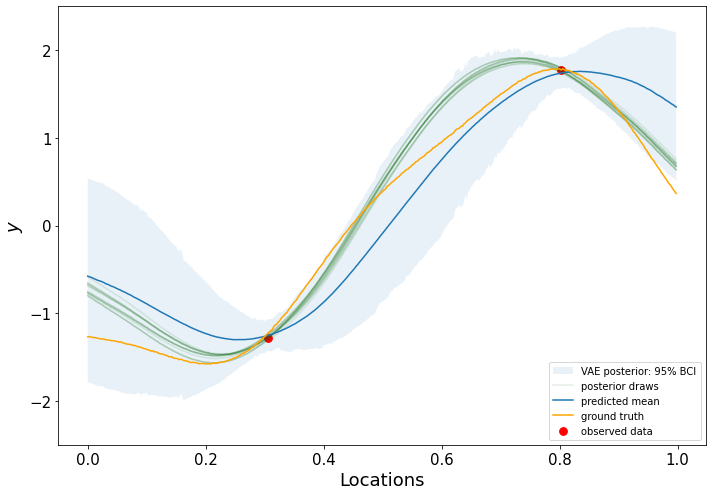

n_datapoints = 4


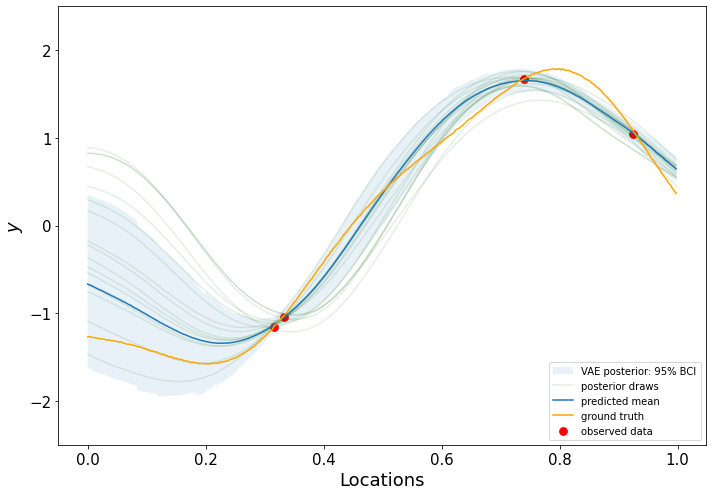

n_datapoints = 6


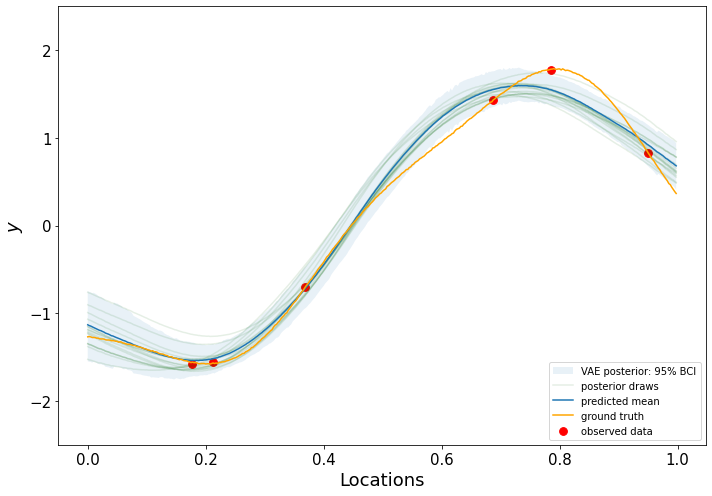

In [ ]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    ax.fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    ax.set_xlabel('Locations', fontsize=18)
    ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    plt.tight_layout()
    plt.show()
    
    save_to_dir = FIG_PATH / 'publication'
    fig.savefig(save_to_dir / f'1DGP_inference_PriorVAE_{idx+2}.jpg', dpi=300)

## Both plots

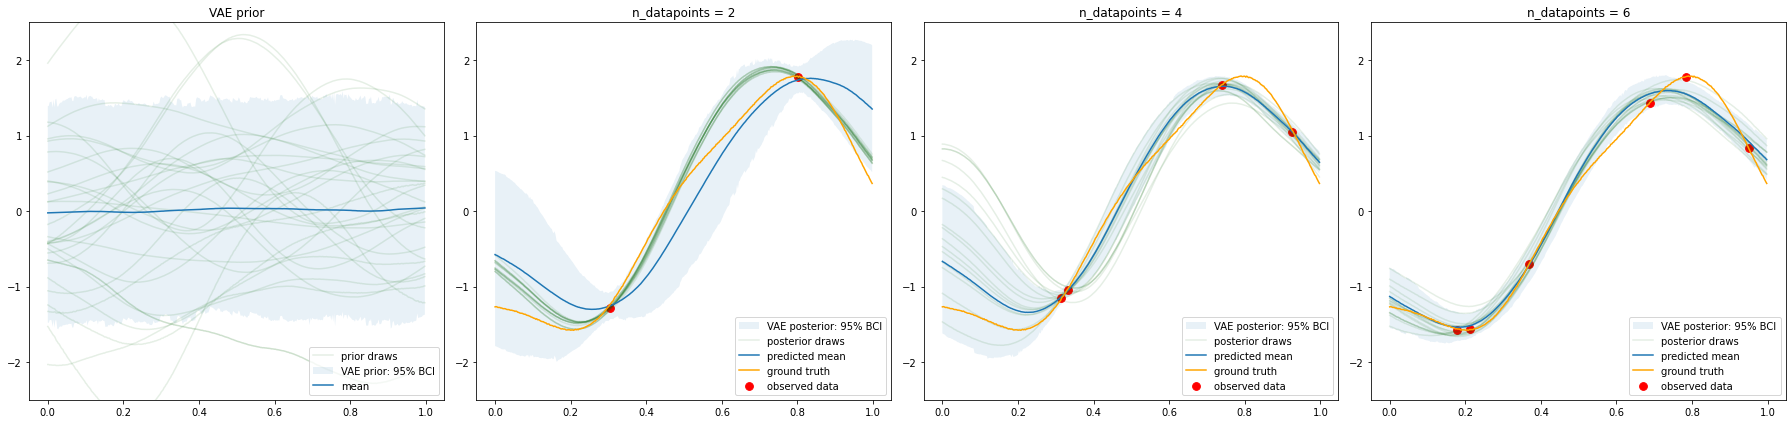

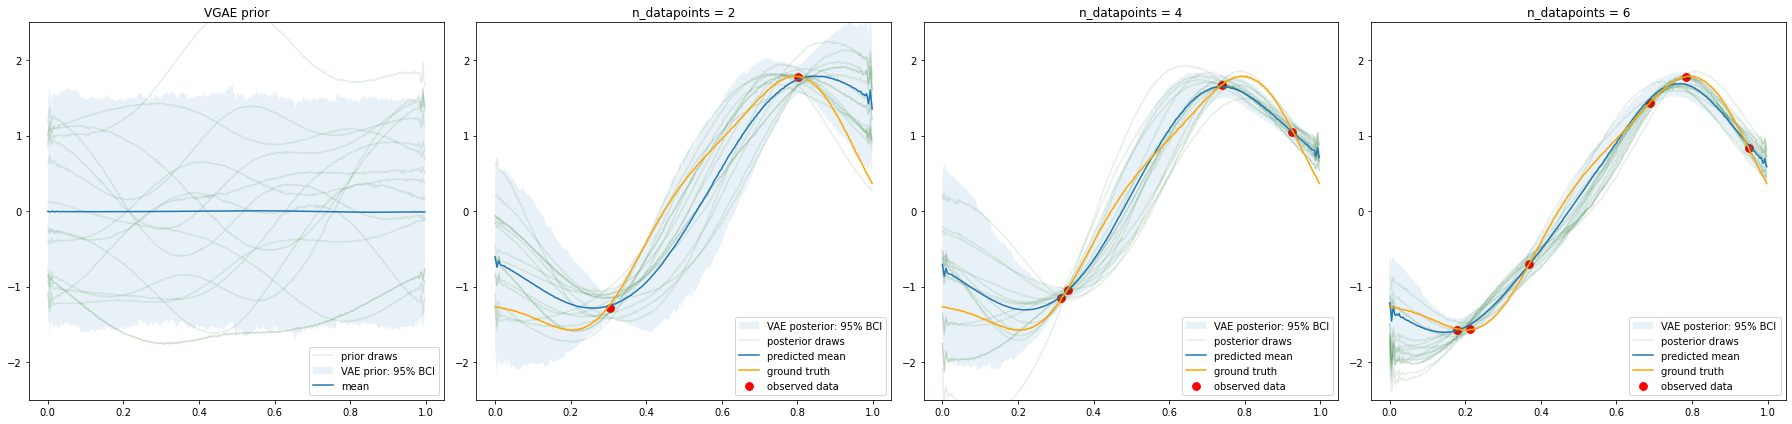

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

In [ ]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgae (2) = 0.20761044323444366
mse_vgae (4) = 0.05168772116303444
mse_vgae (6) = 0.015989668667316437


In [ ]:
for idx, mean in enumerate(vae_mean_post_preds_list):
    mse_vae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vae ({len(obs_locations[idx])}) = {mse_vae}')

mse_vae (2) = 0.166422501206398
mse_vae (4) = 0.05720733106136322
mse_vae (6) = 0.023716256022453308


In [ ]:
mean_post_pred_vae = vae_mean_post_preds_list[-1]
mean_post_pred_vgae = mean_post_preds_list[-1]

mse_vgae = np.mean((gp_draw.flatten() -  mean_post_pred_vgae)**2)
mse_vae = np.mean((gp_draw.flatten() -  mean_post_pred_vae)**2)
print(f'mse_vgae = {mse_vgae}')
print(f'mse_vae = {mse_vae}')

mse_vgae = 0.015989668667316437
mse_vae = 0.023716256022453308


mse_vgae_encoderGraphNorm = 0.03129349276423454

mse_vgae = 0.014667835086584091

mse_vae = 0.023716256022453308

compute mse vgae when using GraphNormalization and see if it reduces, put in table.